In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import json
from collections import defaultdict
from packaging.version import parse as parse_version
import warnings
warnings.filterwarnings('ignore')

import cv2 
import imageio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu, tanh, elu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds
from tensorflow_addons.layers import InstanceNormalization

from keras.utils import plot_model

print("Tensorflow", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


2024-08-07 14:02:44.389907: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 14:02:44.450686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 14:02:45.305126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow 2.12.0
GPU is NOT AVAILABLE


2024-08-07 14:02:46.521852: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
image_shape = (240, 240, 3)
IMG_HEIGHT = image_shape[0]
IMG_WIDTH = image_shape[1]

In [3]:
t1 = "../res/synthTrain/" # synth train
t2 = "../res/realTrain/" # real train
t3 = "../res/synthTest/" # synth test
t4 = "../res/realTest/" # real test

In [4]:
# list of images
t1_images = [t1 + i for i in os.listdir(t1)]
t2_images = [t2 + i for i in os.listdir(t2)]
t3_images = [t3 + i for i in os.listdir(t3)]
t4_images = [t4 + i for i in os.listdir(t4)]

In [5]:
# Images count for each category
print("\n\nTotal Images in each category:\n")
print(f"t1: {len(t1_images)}")
print(f"t2: {len(t2_images)}")
print(f"t3: {len(t3_images)}")
print(f"t4: {len(t4_images)}")



Total Images in each category:

t1: 904
t2: 852
t3: 189
t4: 174




Sample Training Images from each category:



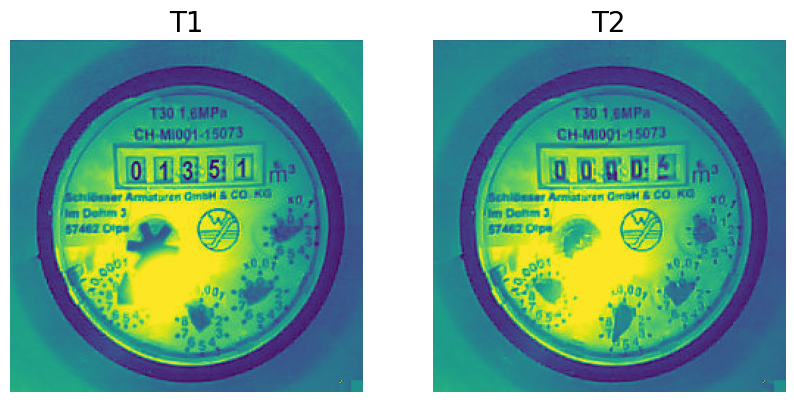

In [6]:
# Priting sample images from each category
print("\n\nSample Training Images from each category:\n")
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(t1_images[5]))
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(t2_images[2]))
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()



Sample Test Images from each category:



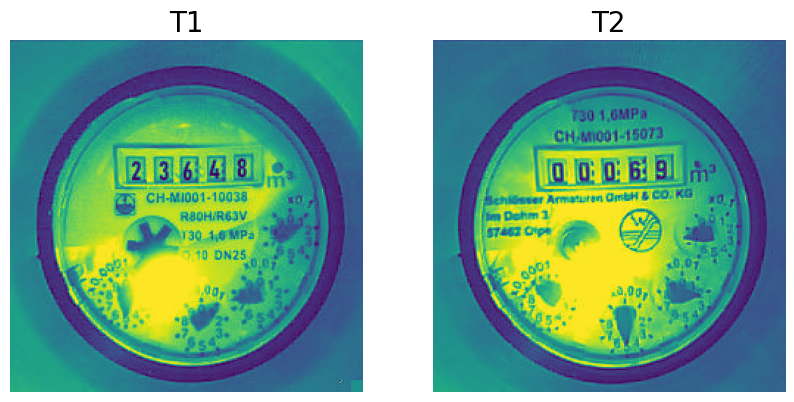

In [7]:
# Priting sample images from each category
print("\n\nSample Test Images from each category:\n")
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(t3_images[5]))
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(t4_images[10]))
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

In [8]:
# function to load images and resize
def load_images(img_list):
    img_arr = []
    for img in img_list:
        img = Image.open(img)
        img_arr.append(np.array(img))
    return np.array(img_arr)

In [9]:
t1_images = load_images(t1_images)
t2_images = load_images(t2_images)
t3_images = load_images(t3_images)
t4_images = load_images(t4_images)

In [10]:
# Function to resize real images to 124x124
def image_resize(imglist,x,y):
  t2_images_resize = []
  for img in imglist:
    resize_image = cv2.resize(img, (y, x))
    t2_images_resize.append(np.array(resize_image))
  return np.array(t2_images_resize)

In [11]:
#t2_images = image_resize(t2_images,256,256)
#t4_images = image_resize(t4_images,256,256)

In [12]:
# Get a list of all image files in the folder
image_files_train = [f for f in os.listdir(t1) if f.endswith('.jpg')]
print(type(image_files_train))
image_files_test = [f for f in os.listdir(t3) if f.endswith('.jpg')]
print(type(image_files_test))

<class 'list'>
<class 'list'>


In [13]:
def sharpen_images(img_list):
    img_arr = []
    for img in img_list:
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        image_sharp = cv2.filter2D(img, ddepth=-1, kernel=kernel)
        deblurred_image = cv2.GaussianBlur(image_sharp, (1, 1), 0)
        img_arr.append(np.array(deblurred_image))  # Convert to NumPy array and append to the list
    return np.array(img_arr)  # Convert the list to a NumPy ndarray

In [14]:
#t1_images = image_resize(t1_images,256,256)
t1_images = sharpen_images(t1_images)

In [15]:
#t3_images = image_resize(t3_images,256,256)
t3_images = sharpen_images(t3_images)

In [16]:
# information of training dataset
print("\n\nInformation of dataset:\n")
print(f"t1: {t1_images.shape}")
print(f"t2: {t2_images.shape}")



Information of dataset:

t1: (904, 240, 240)
t2: (852, 240, 240)


In [17]:
# information of test dataset
print("\n\nInformation of dataset:\n")
print(f"t1: {t3_images.shape}")
print(f"t2: {t4_images.shape}")



Information of dataset:

t1: (189, 240, 240)
t2: (174, 240, 240)


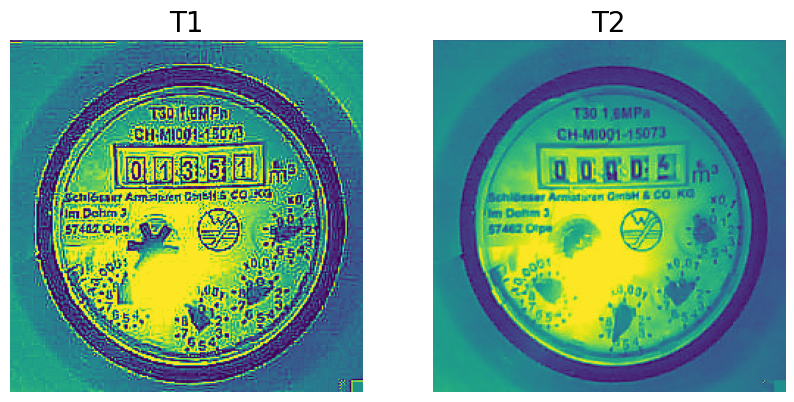

In [18]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t1_images[5])
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t2_images[2])
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

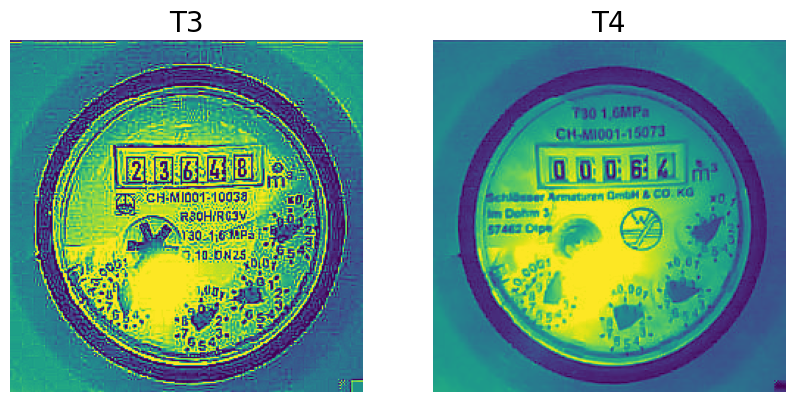

In [19]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t3_images[5])
plt.title("T3", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t4_images[2])
plt.title("T4", fontsize=20)
plt.axis("off")
plt.show()

In [20]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

In [21]:
def preprocess_images(img):
    img = tf.expand_dims(img, axis=-1)  # Add a channel dimension
    img = tf.image.random_flip_left_right(img)
    img = normalize_img(img)
    return img

In [22]:
t1_images = [preprocess_images(image) for image in t1_images]
t2_images = [preprocess_images(image) for image in t2_images]
t3_images = [preprocess_images(image) for image in t3_images]
t4_images = [preprocess_images(image) for image in t4_images]

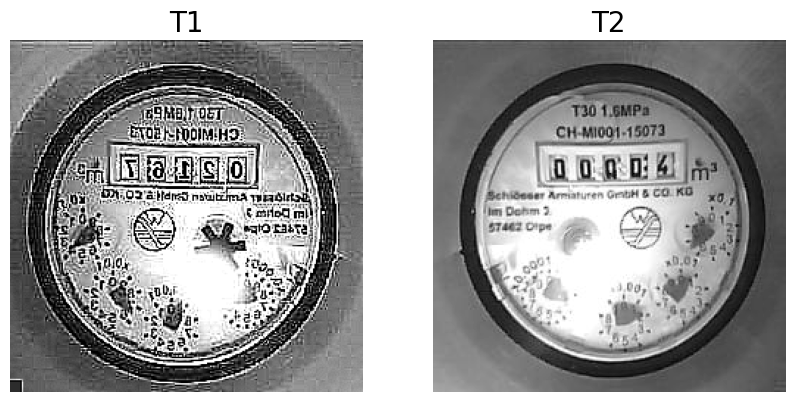

In [23]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t1_images[12],cmap="gray")
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t2_images[6],cmap="gray")
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

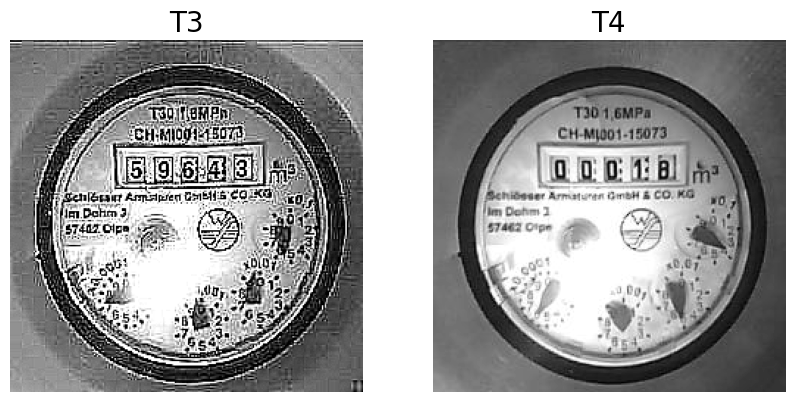

In [24]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t3_images[12],cmap="gray")
plt.title("T3", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t4_images[6],cmap="gray")
plt.title("T4", fontsize=20)
plt.axis("off")
plt.show()

In [25]:
from tensorflow import keras
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 128
batch_size = 1

In [26]:
def create_dataset(images, buffer_size, batch_size):
    return (
        tf.data.Dataset.from_tensor_slices(images)
        .cache()
        .shuffle(buffer_size)
        .batch(batch_size)
    )

In [27]:
# Create datasets
t1_dataset = create_dataset(t1_images, buffer_size, batch_size)
t2_dataset = create_dataset(t2_images, buffer_size, batch_size)
t3_dataset = create_dataset(t3_images, buffer_size, batch_size)
t4_dataset = create_dataset(t4_images, buffer_size, batch_size)

In [28]:
# Define custom directory for saving datasets
custom_dir = '../tf_datasets'
os.makedirs(custom_dir, exist_ok=True)

In [29]:
# Save the datasets to the custom directory
tf.data.experimental.save(t1_dataset, os.path.join(custom_dir, 't1_dataset'))
tf.data.experimental.save(t2_dataset, os.path.join(custom_dir, 't2_dataset'))
tf.data.experimental.save(t3_dataset, os.path.join(custom_dir, 't3_dataset'))
tf.data.experimental.save(t4_dataset, os.path.join(custom_dir, 't4_dataset'))

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


2024-08-07 14:02:50.413368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [904,240,240,1]
	 [[{{node Placeholder/_0}}]]
2024-08-07 14:02:50.413588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [904,240,240,1]
	 [[{{node Placeholder/_0}}]]
2024-08-07 14:02:50.709661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float 

In [30]:
# Save the dataset specifications
specs = {
    't1_spec': t1_dataset.element_spec,
    't2_spec': t2_dataset.element_spec,
    't3_spec': t3_dataset.element_spec,
    't4_spec': t4_dataset.element_spec
}

np.save(os.path.join(custom_dir, 'dataset_specs.npy'), specs)

print("Datasets saved to custom directory:", custom_dir)

Datasets saved to custom directory: ../tf_datasets
